In [27]:
from anotherJEPA3 import TrajectoryDataset, flip_and_shift_augmentation
import random
import torch
import PIL
import matplotlib.pyplot as plt


In [28]:
# Example augmentation function
def example_augmentations(states, actions):
    """
    Example augmentation function for the TrajectoryDataset.
    Args:
        states (Tensor): Tensor of shape (T, 2, 64, 64).
        actions (Tensor): Tensor of shape (T-1, 2).
    
    Returns:
        Tuple[Tensor, Tensor]: Augmented states and actions.
    """
    # Random horizontal flip
    if random.random() > 0.5:
        states = torch.flip(states, dims=[-1])  # Flip along the width
        actions[:, 0] = -actions[:, 0]  # Invert x-axis action

    # Random vertical flip
    if random.random() > 0.5:
        states = torch.flip(states, dims=[-2])  # Flip along the height
        actions[:, 1] = -actions[:, 1]  # Invert y-axis action


    # Check for edges of the agent
    _, _, width_non_zeros = torch.nonzero((states[:, 0] != 0), as_tuple=True)
    width_min = width_non_zeros.min().item()
    width_max = width_non_zeros.max().item()

    # Check for edges of the walls
    wall_non_zeros = torch.nonzero(states[-1, 1, 0, 5:-5] != 0)
    wall_min = wall_non_zeros.min().item()
    wall_max = wall_non_zeros.max().item()

    # Identify range of the data (lowest and highest index where it is not empty space)
    global_min_all = min(width_min, width_max, wall_min, wall_max)
    global_max_all = max(width_min, width_max, wall_min, wall_max)


    # Randomly determine shift (without breaking out of the box)
    min_shift = 5 - global_min_all
    max_shift = 59 - global_max_all
    shift = torch.randint(min_shift, max_shift + 1, size=(1,))

    print("shifting:", shift.item())

    # Split up to make sure the box remains intact
    left_edge = states[:, :, :, 0:5]
    core = states[:, :, :, 5:-5]  # First part (before the shift)
    right_edge = states[:, :, :, -5:]

    # Shift left or right
    slice1 = core[:, :, :, 0:-shift]  # First part (before the shift)
    slice2 = core[:, :, :, -shift:]   # Second part (after the shift)

    shifted_core = torch.cat((slice2, slice1), dim=3)

    # Recombine
    shifted = torch.cat((left_edge, shifted_core, right_edge), dim=3)
    shifted.shape

    return shifted, actions

shifting: 5


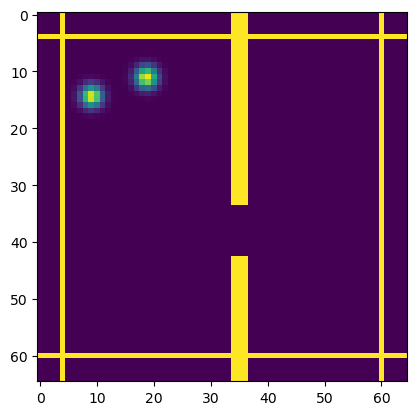

In [29]:
dataset = TrajectoryDataset('../data/states.npy', '../data/actions.npy', augmentations=flip_and_shift_augmentation)
import matplotlib.pyplot as plt
states, actions = dataset[8]  # This will print "augmenting"

plt.imshow(states[-1][0].numpy() + states[0][0].numpy() + states[0][1].numpy())

shifting: 5


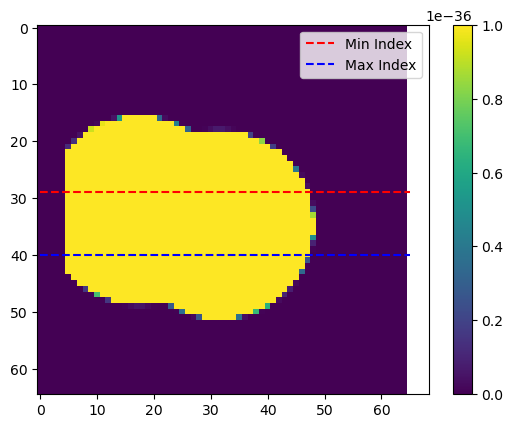

In [40]:
states, actions = dataset[4]  # This will print "augmenting"
start = states[0][0]  # Example indexing to get the tensor
end = states[-1][0]
capped_tensor = torch.clamp(start+end, max=1E-36)


_, height_non_zeros, _ = torch.nonzero((states[:, 0] > 0.001), as_tuple=True)
height_min = height_non_zeros.min().item()
height_max = height_non_zeros.max().item()


plt.imshow(capped_tensor.numpy(), cmap="viridis")
plt.colorbar()  # Optional: To display the color scale

# Plot vertical lines at min and max height indices
plt.hlines(height_min, xmin=0, xmax=capped_tensor.shape[1], colors='red', linestyle='--', label="Min Index")
plt.hlines(height_max, xmin=0, xmax=capped_tensor.shape[1], colors='blue', linestyle='--', label="Max Index")

# Optional: Add a legend for the lines
plt.legend()

# Show the plot
plt.show()


shifting: -13
6 46
28 30
6 46


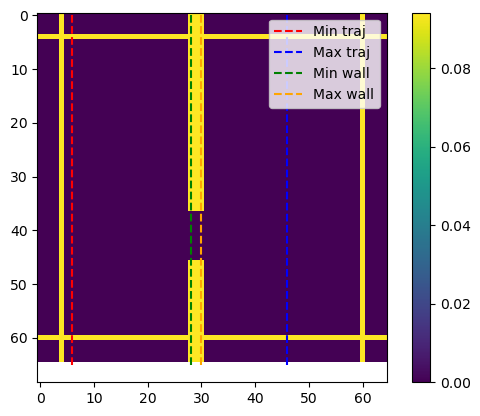

Random number between the range: 3


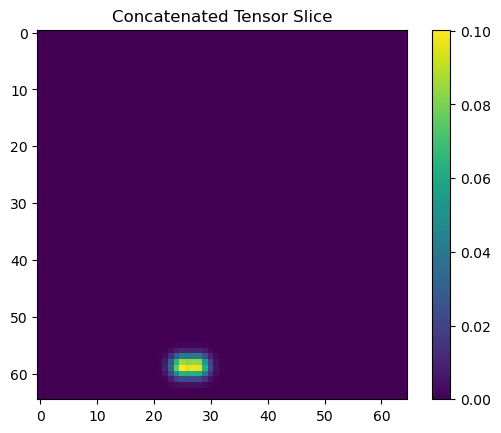

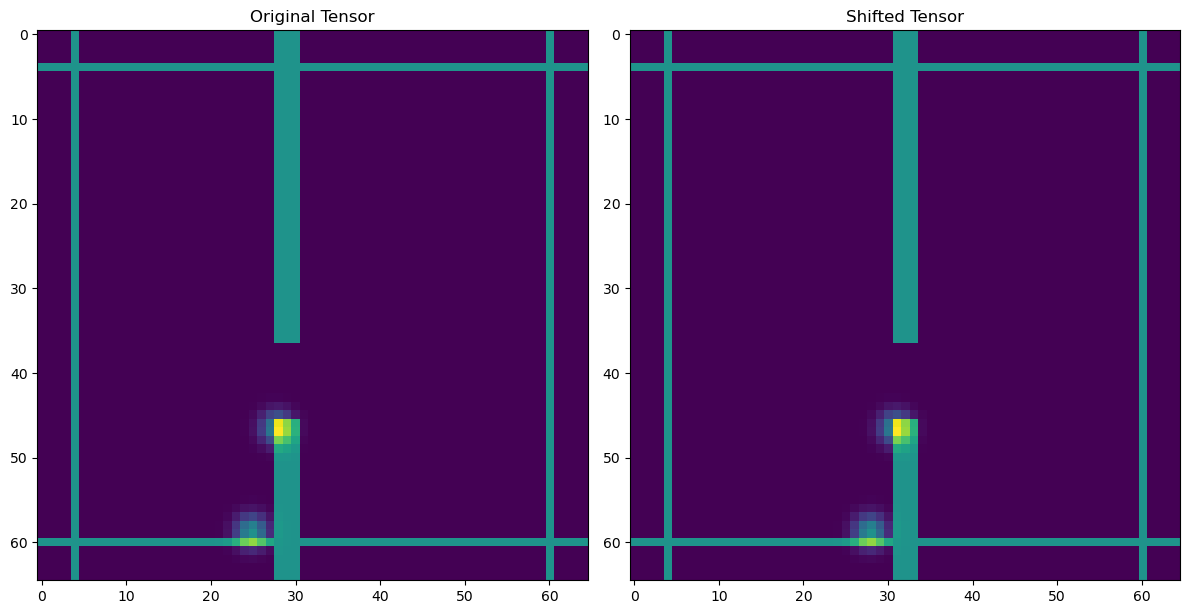

In [33]:
states, actions = dataset[6]  # This will print "augmenting"
start = states[0][0]  # Example indexing to get the tensor
end = states[-1][0]
walls = states[0][1]
capped_tensor = torch.clamp(start+end, max=1E-36)


_, _, width_non_zeros = torch.nonzero((states[:, 0] != 0), as_tuple=True)
width_min = width_non_zeros.min().item()
width_max = width_non_zeros.max().item()

wall_non_zeros = torch.nonzero(states[-1, 1, 0, 5:-5] != 0)
wall_min = wall_non_zeros.min().item()+5
wall_max = wall_non_zeros.max().item()+5

global_min_all = min(width_min, width_max, wall_min, wall_max)
global_max_all = max(width_min, width_max, wall_min, wall_max)

print(width_min, width_max)
print(wall_min, wall_max)
print(global_min_all, global_max_all)

plt.imshow(capped_tensor.numpy()+walls.numpy(), cmap="viridis")
plt.colorbar()  # Optional: To display the color scale

# Plot vertical lines at min and max width indices
plt.vlines(width_min, ymin=0, ymax=capped_tensor.shape[1], colors='red', linestyle='--', label="Min traj")
plt.vlines(width_max, ymin=0, ymax=capped_tensor.shape[1], colors='blue', linestyle='--', label="Max traj")

plt.vlines(wall_min, ymin=0, ymax=capped_tensor.shape[1], colors='green', linestyle='--', label="Min wall")
plt.vlines(wall_max, ymin=0, ymax=capped_tensor.shape[1], colors='orange', linestyle='--', label="Max wall")

# Optional: Add a legend for the lines
plt.legend()

# Show the plot
plt.show()

min_shift = 5 - global_min_all
max_shift = 59 - global_max_all
shift = torch.randint(min_shift, max_shift + 1, size=(1,))  # +1 because max is exclusive

print("Random number between the range:", shift.item())

# slice1 = states[:, :, :, 0:-shift]  # First part (before the shift)
# slice2 = states[:, :, :, -shift:]   # Second part (after the shift)

# shifted = torch.cat((slice2, slice1), dim=3)

left_edge = states[:, :, :, 0:5]
core = states[:, :, :, 5:-5]  # First part (before the shift)
right_edge = states[:, :, :, -5:]

slice1 = core[:, :, :, 0:-shift]  # First part (before the shift)
slice2 = core[:, :, :, -shift:]   # Second part (after the shift)

shifted_core = torch.cat((slice2, slice1), dim=3)


shifted = torch.cat((left_edge, shifted_core, right_edge), dim=3)
shifted.shape

shifted_start = shifted[0][0]  # Example indexing to get the tensor
shifted_end = shifted[-1][0]
shifted_capped = torch.clamp(start+end, max=1E-1)
shifted_walls = shifted[0][1]

# Plot the concatenated tensor (show the first frame as an example)
plt.imshow(start+shifted_start, cmap="viridis")  # Assuming you want to plot the first image
plt.colorbar()  # Optional: To display the color scale
plt.title("Concatenated Tensor Slice")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot original (non-shifted) image
axes[0].imshow(start + end + walls, cmap="viridis")
axes[0].set_title("Original Tensor")

# Plot shifted image
axes[1].imshow(shifted_start + shifted_end + shifted_walls, cmap="viridis")
axes[1].set_title("Shifted Tensor")

plt.tight_layout()
plt.show()

In [ ]:
# states, actions = dataset[6]  # This will print "augmenting"
# start = states[0][0]  # Example indexing to get the tensor
# end = states[-1][0]
# walls = states[0][1]
# capped_tensor = torch.clamp(start+end, max=1E-36)


# Check for edges of the agent
_, _, width_non_zeros = torch.nonzero((states[:, 0] != 0), as_tuple=True)
width_min = width_non_zeros.min().item()
width_max = width_non_zeros.max().item()

# Check for edges of the walls
wall_non_zeros = torch.nonzero(states[-1, 1, 0, 5:-5] != 0)
wall_min = wall_non_zeros.min().item()
wall_max = wall_non_zeros.max().item()

# Identify range of the data (lowest and highest index where it is not empty space)
global_min_all = min(width_min, width_max, wall_min, wall_max)
global_max_all = max(width_min, width_max, wall_min, wall_max)


# Randomly determine shift (without breaking out of the box)
min_shift = 5 - global_min_all
max_shift = 59 - global_max_all
shift = torch.randint(min_shift, max_shift + 1, size=(1,))

print("shifting:", shift.item())

# Split up to make sure the box remains intact
left_edge = states[:, :, :, 0:5]
core = states[:, :, :, 5:-5]  # First part (before the shift)
right_edge = states[:, :, :, -5:]

# Shift left or right
slice1 = core[:, :, :, 0:-shift]  # First part (before the shift)
slice2 = core[:, :, :, -shift:]   # Second part (after the shift)

shifted_core = torch.cat((slice2, slice1), dim=3)

# Recombine
shifted = torch.cat((left_edge, shifted_core, right_edge), dim=3)
shifted.shape



In [258]:
states[:, :, 0:global_min_all-shift] states[:, :, global_min_all-shift:-1]

torch.Size([17, 2, 65, 65])

In [375]:
shift

tensor([2])

In [376]:
slice0 = states[:, :, :, 0:5]
slice1 = states[:, :, :, 5:5-shift]  # First part (before the shift)
slice2 = states[:, :, :, 5-shift:-5]   # Second part (after the shift)
slice3 = states[:, :, :, -5:]
shifted = torch.cat((slice0, slice2, slice1, slice3), dim=3)


In [383]:
left_edge = states[:, :, :, 0:5]
core = states[:, :, :, 5:-5]  # First part (before the shift)
right_edge = states[:, :, :, -5:]

slice1 = core[:, :, :, 0:-shift]  # First part (before the shift)
slice2 = core[:, :, :, -shift:]   # Second part (after the shift)

shifted_core = torch.cat((slice2, slice1), dim=3)


shifted = torch.cat((left_edge, shifted_core, right_edge), dim=3)
shifted.shape


torch.Size([17, 2, 65, 65])

In [377]:
shifted = torch.cat((slice0, slice2, slice1, slice3), dim=3)


In [378]:
print("Shape of slice0:", slice0.shape)
print("Shape of slice1:", slice1.shape)
print("Shape of slice2:", slice2.shape)
print("Shape of slice3:", slice3.shape)

# Concatenate the slices along the 4th dimension (width axis)
shifted = torch.cat((slice0, slice2, slice1, slice3), dim=3)

# Check the shape of the concatenated tensor
print("Shape of concatenated tensor:", shifted.shape)

Shape of slice0: torch.Size([17, 2, 65, 5])
Shape of slice1: torch.Size([17, 2, 65, 0])
Shape of slice2: torch.Size([17, 2, 65, 57])
Shape of slice3: torch.Size([17, 2, 65, 5])
Shape of concatenated tensor: torch.Size([17, 2, 65, 67])


In [373]:
shifted.shape

torch.Size([17, 2, 65, 68])

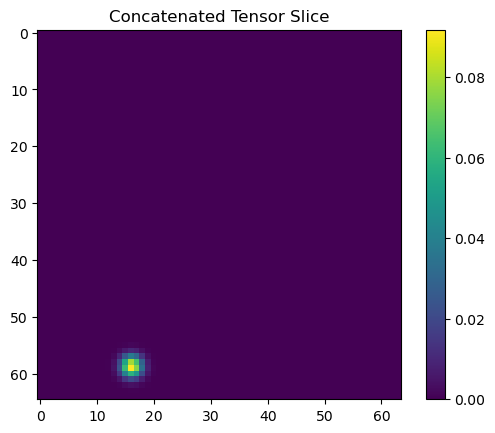

In [341]:
shift = 20
slice1 = states[:, :, :, 0:shift]  # First part
slice2 = states[:, :, :, shift:-1]  # Second part

# Concatenate the slices along the 2nd axis (width axis)
concatenated = torch.cat((slice2, slice1), dim=3)

# Plot the concatenated tensor (show the first frame as an example)
plt.imshow(concatenated[0][0].numpy(), cmap="viridis")  # Assuming you want to plot the first image
plt.colorbar()  # Optional: To display the color scale
plt.title("Concatenated Tensor Slice")
plt.show()

In [219]:
states, actions = dataset[7]  # This will print "augmenting"
start = states[0][0]  # Example indexing to get the tensor
end = states[-1][0]


_, _, width_non_zeros = torch.nonzero((states[:, 1, ] != 0), as_tuple=True)
width_min = width_non_zeros.min().item()
width_max = width_non_zeros.max().item()

normal
augmenting


In [233]:
wall_non_zeros = torch.nonzero(states[-1, 1, 0, 5:-5] != 0)
wall_min = wall_non_zeros.min().item()
wall_max = wall_non_zeros.max().item()


tensor([[38],
        [39],
        [40]])

In [231]:
states[-1, 1, 0, 5:-5].numpy()

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.09413984, 0.09413984,
       0.09413984, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

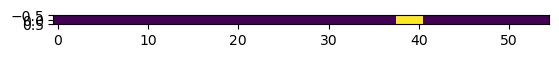

In [234]:
plt.imshow(states[-1, 1, 0:1, 5:-5].numpy())

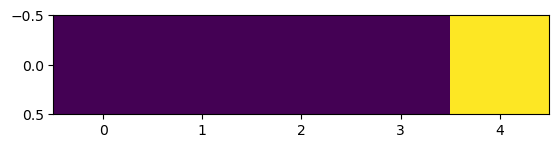

In [366]:
plt.imshow(states[-1, 1, 0:1, 0:5].numpy())

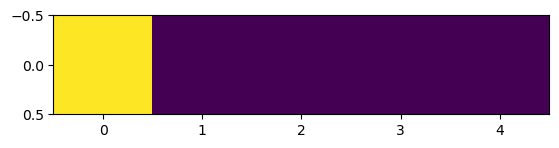

In [369]:
plt.imshow(states[-1, 1, 0:1, -5:].numpy())

In [221]:
(states[:, 1, ] != 0).shape

torch.Size([17, 65, 65])

In [132]:
x, _ = torch.nonzero((states[-1][0] != 0), as_tuple=True)
x.min().item()

38

In [167]:
_, b, _ = torch.nonzero((states[:, 0] != 0), as_tuple= True)

In [164]:
(states[:, 0] != 0).shape

torch.Size([17, 65, 65])

In [175]:
_, x, _ = torch.nonzero((states[:, 1] != 0), as_tuple=True)
print(x.min().item())
print(x.max().item())

0
64


In [168]:
x, _ = torch.nonzero((states[-1][0] != 0), as_tuple=True)
x.min().item()

38

In [108]:
torch.nonzero((states[-1][0] != 0))[:,0].shape

torch.Size([811])

In [109]:
torch.nonzero((states[-1][0] != 0))[:, 0].reshape(states[-1][0].shape)

RuntimeError: shape '[65, 65]' is invalid for input of size 811

In [69]:
y.shape

torch.Size([811])

In [47]:
states[0][1].numpy()[0]

array([0.        , 0.        , 0.        , 0.        , 0.09413984,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09413984, 0.09413984, 0.09413984, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09413984, 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)